### Preparing the datasets

Importing libraries

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tenalg import multi_mode_dot
from scipy.linalg import qr, solve
import numpy as np

# Definition of the HOSVD and T-HOSVD algorithm

In [2]:
def hosvd(tensor):
    """
    Compute and apply HOSVD on a tensor.

    Parameters:
    - tensor: input tensor (numpy array).

    Returns:
    - core: core tensor.
    - factors: list of factor matrices.
    - singular_values: list of singular values for each mode.
    """
    modes = tensor.ndim
    factors = []
    singular_values = []  

    for mode in range(modes):
        unfold = np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))
        
        U, S, _ = np.linalg.svd(unfold, full_matrices=False)
        singular_values.append(S)
        
        factors.append(U)
        
    
    core = tensor.copy()
    for mode in range(modes):
        core = np.tensordot(core, factors[mode].T, axes=(0, 1))
    
    return core, factors, singular_values

In [3]:
def t_hosvd(tensor, ranks):
    """
    Compute and apply Truncated HOSVD (T-HOSVD) on a tensor.

    Parameters:
    - tensor: input tensor (numpy array).
    - ranks: list of ranks.

    Returns:
    - core: core tensor.
    - factors: list of factor matrices.
    - singular_values: list of singular values for each mode.
    """
    modes = tensor.ndim 
    factors = [] 
    singular_values = [] 

    for mode in range(modes):
        unfold = np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))
        U, S, _ = np.linalg.svd(unfold, full_matrices=False)
        
        singular_values.append(S)
        
        R = ranks[mode]
        factors.append(U[:, :R])
    
    core = tensor.copy()
    for mode in range(modes):
        core = np.tensordot(core, factors[mode].T, axes=(0, 1))
    
    return core, factors, singular_values

# Data preparation and exploration

In [4]:
dataset = fetch_olivetti_faces()
images = dataset.images  # (400, 64, 64)
labels = dataset.target  # (400,)

test_indices = np.arange(9, len(labels), 10) 
train_indices = np.setdiff1d(np.arange(len(labels)), test_indices)
train_images = images[train_indices]
test_images = images[test_indices]
train_labels = labels[train_indices]
test_labels = labels[test_indices]

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (360, 64, 64)
Test images shape: (40, 64, 64)
Train labels shape: (360,)
Test labels shape: (40,)


The dataset is already normalized, ordered and splitted. 

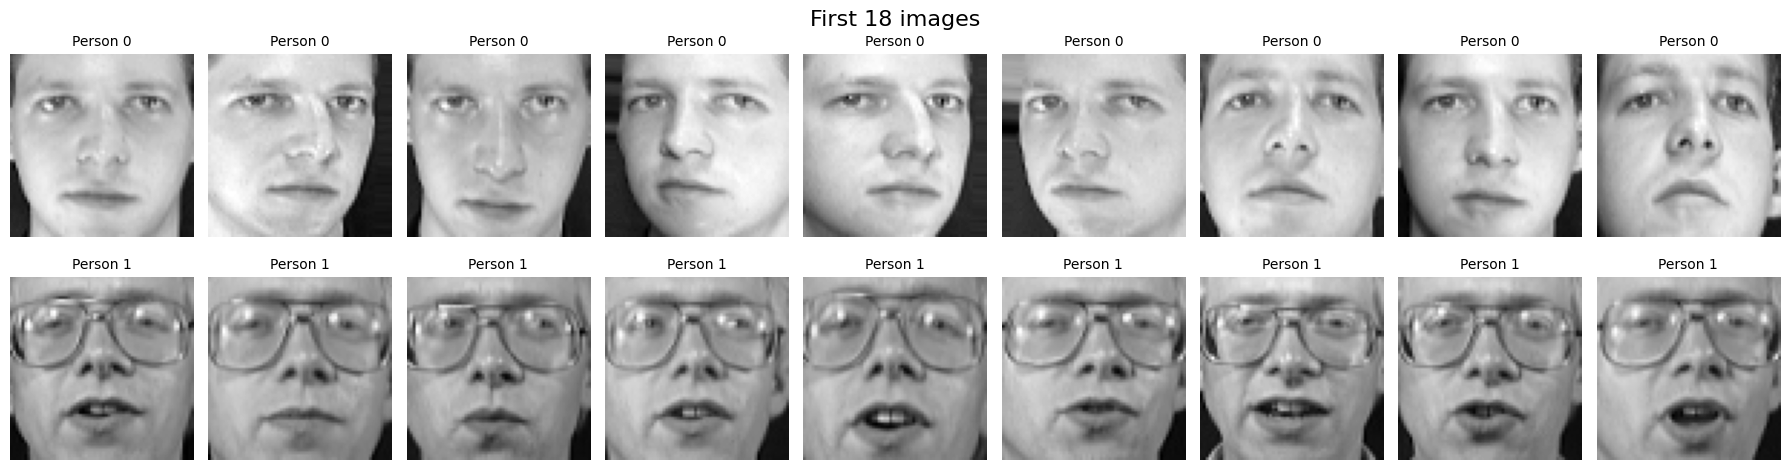

In [5]:
num_images = 18
fig, axes = plt.subplots(2, 9, figsize=(18, 5))
fig.suptitle('First 18 images', fontsize=16)

for i in range(num_images):
    row = i // 9 
    col = i % 9 
    axes[row, col].imshow(train_images[i], cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Person {train_labels[i]}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()



Let's re-organise the dataset as a tensor, where the first mode refers to the pixels, the second to the expression and the third to the person identity.

In [6]:
n_i=train_images[0].shape[0]*train_images[0].shape[1]
n_e=9
n_p=40
print(f"n_i =",n_i,"ne =",n_e,"n_p =",n_p)

n_i = 4096 ne = 9 n_p = 40


In [7]:
tensor = np.empty((n_i, n_e, n_p))

for person in range(n_p):
    start_idx = person * n_e
    end_idx = start_idx + n_e
    person_images = train_images[start_idx:end_idx]  # (10, 64, 64)
    
    tensor[:, :, person] = person_images.reshape(n_e, -1).T

print(f"Tensor dimension: {tensor.shape}")

Tensor dimension: (4096, 9, 40)


Visualize the 35-th, 36-th adn 27-th people

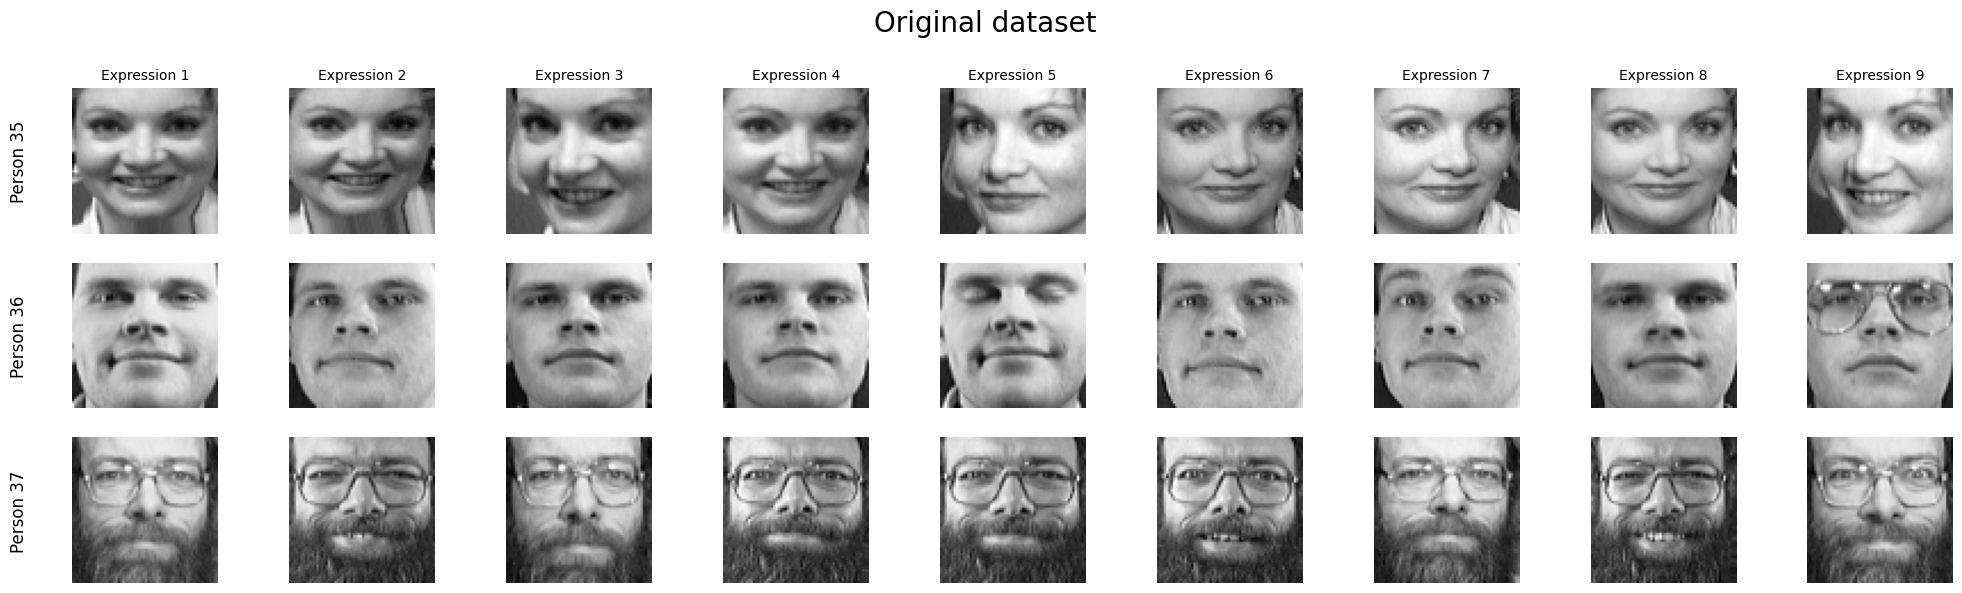

In [8]:
person_indices = [34,35,36]  

fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))
fig.suptitle(f'Original dataset', fontsize=20)


for row, person_index in enumerate(person_indices):
    
    person_images = tensor[:, :, person_index].T 
    person_images = person_images.reshape(-1, 64, 64)
    
    
    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)
    
    
    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()


# HOSVD 
### tensor =S x F x G x H

In [9]:
S, factors, singulars = hosvd(tensor)
F,G,H = factors

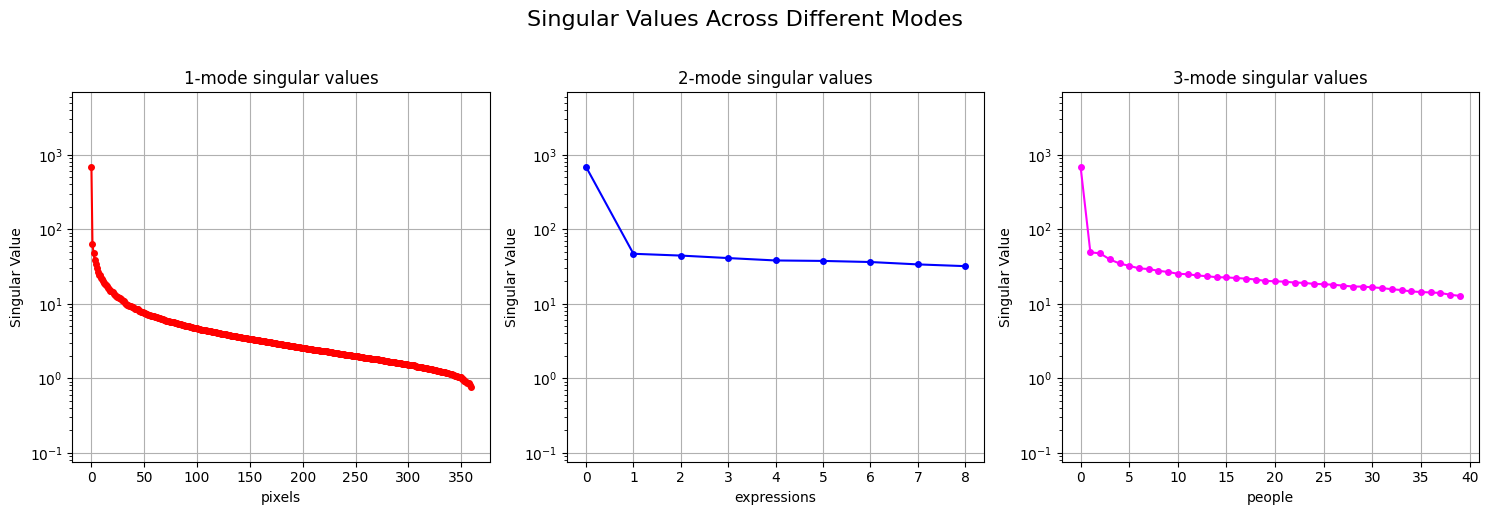

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["1-mode singular values", "2-mode singular values", "3-mode singular values"]
ascisses = ["pixels", "expressions", "people"]
colors = ['red', 'blue', 'magenta']

# Trova il valore minimo e massimo dei valori singolari per uniformare la scala
all_singular_values = np.concatenate(singulars)
y_min, y_max = all_singular_values.min()*0.1, all_singular_values.max()*10

for i, (ax, singular, title, color, ascissa) in enumerate(zip(axes, singulars, titles, colors,ascisses)):
    ax.plot(singular, marker='o', linestyle='-', color=color, markersize=4)
    ax.set_yscale('log')  # Scala logaritmica sull'asse Y
    ax.set_ylim(y_min, y_max)  # Uniforma la scala Y
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(f"{ascissa}")
    ax.set_ylabel("Singular Value")
    ax.grid(True)

# Aggiunta di un titolo generale
plt.suptitle("Singular Values Across Different Modes", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [11]:
singular_first_mode = singulars[0] 

Check of the shapes

In [12]:
print(f"S shape: {S.shape}")
print(f"F shape: {F.shape}")
print(f"G shape: {G.shape}")
print(f"H shape: {H.shape}")

S shape: (360, 9, 40)
F shape: (4096, 360)
G shape: (9, 9)
H shape: (40, 40)


Let's compute the tensor C=S x F x G

In [13]:
C=tl.tenalg.multi_mode_dot(S,[F, G])
print(f"C shape: {C.shape}")

C shape: (4096, 9, 40)


### Visualizing decomposition and the recostructed images

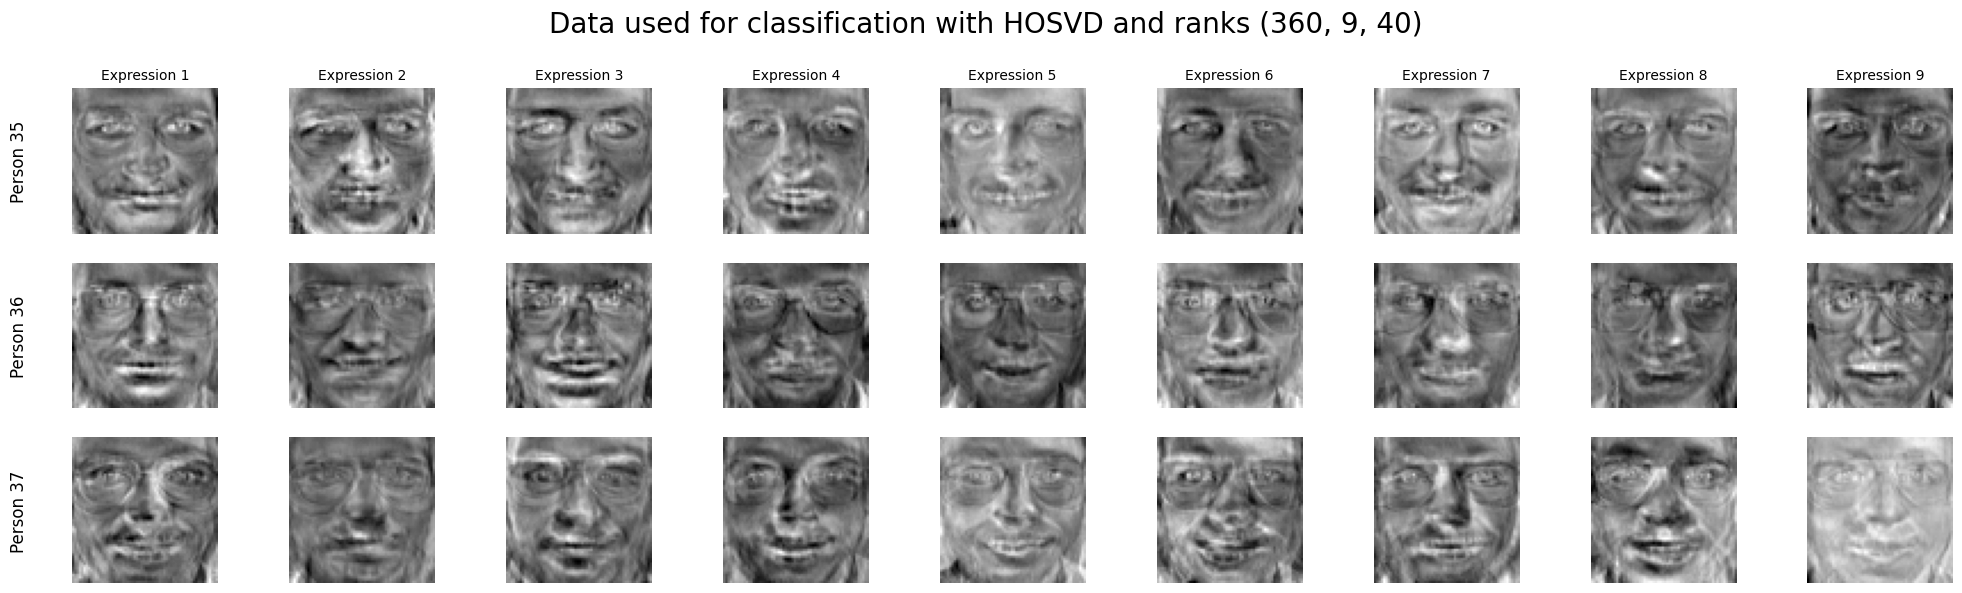

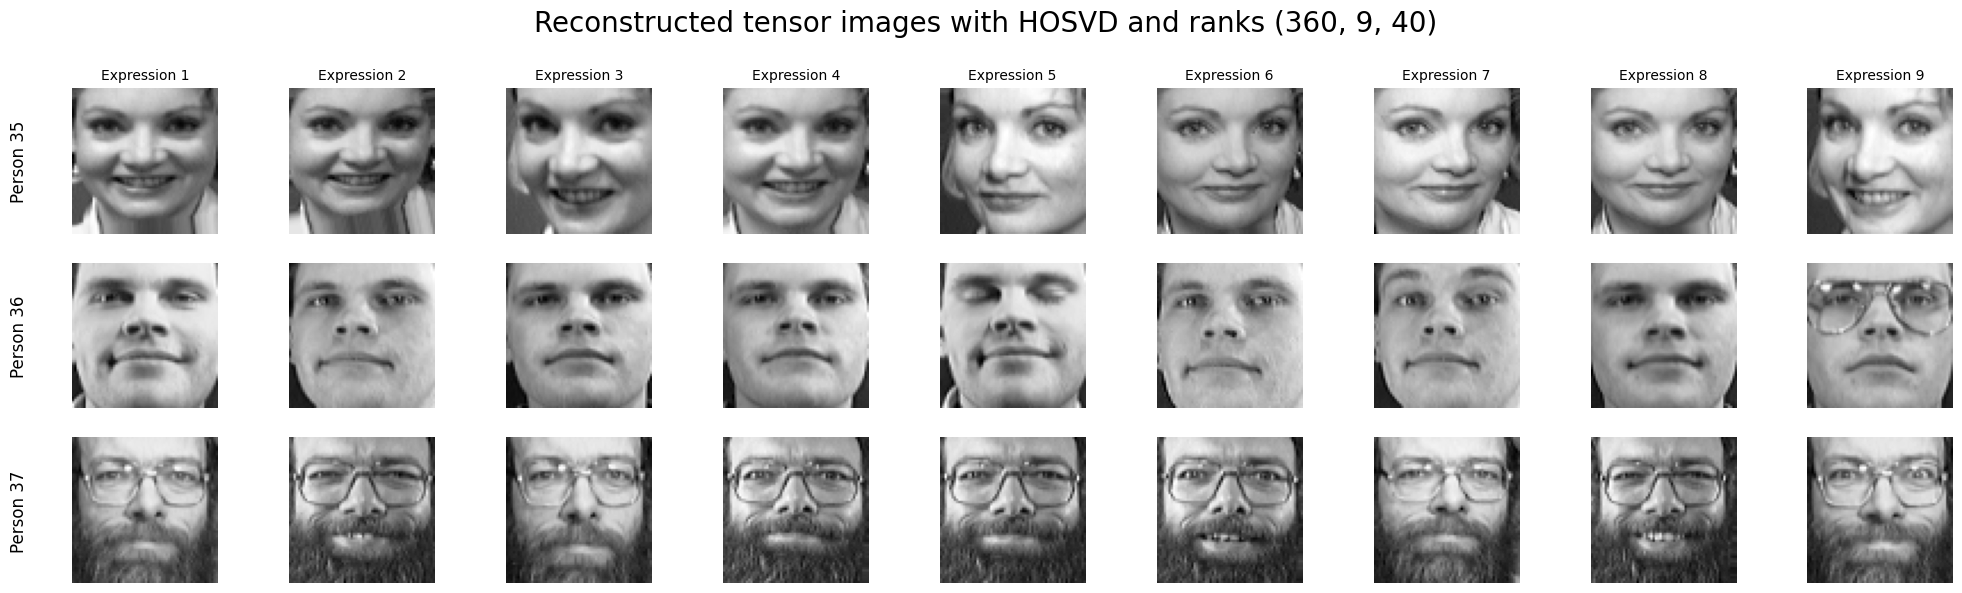

In [14]:
fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))

fig.suptitle(f'Data used for classification with HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = C[:, :, person_index].T  
    person_images = person_images.reshape(-1, 64, 64) 

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

A= tl.tenalg.mode_dot(C, H, mode=2)

fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))
fig.suptitle(f'Reconstructed tensor images with HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = A[:, :, person_index].T  
    person_images = person_images.reshape(-1, 64, 64) 

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()



## Classification

In [15]:
C_e_list=[]
for e in range(n_e):
    C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
    C_e_list.append(C_e)

In [16]:
B_e_list = []
for C_e in C_e_list:
    B_e = F.T @ C_e
    B_e_list.append(B_e)

ON THE TRAINING SET

In [17]:
misclassified_qr=0

# Classification algorithm
for index in range(0,train_images.shape[0]-1):
    z=train_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if train_labels[index]!=person_with_min_distance:
        misclassified_qr+=1

print(f'Results on the training set:')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/train_labels.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

Results on the training set:
Number of misclassified images: 0
Accuracy: 100.00%


ON THE TESTING SET

In [18]:
misclassified_qr=0

# Classification algorithm
for index in range(0,test_images.shape[0]-1):
    z=test_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if test_labels[index] != person_with_min_distance:
        misclassified_qr+=1

print(f'Results on the testing set:')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/test_images.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

Results on the testing set:
Number of misclassified images: 3
Accuracy: 92.50%


# T-HOSVD

Low rank approximation

In [19]:
ranks=[10,n_e,n_p]
S, factors, singulars = t_hosvd(tensor,ranks)
F,G,H = factors
print(f"S shape: {S.shape}")
print(f"F shape: {F.shape}")
print(f"G shape: {G.shape}")
print(f"H shape: {H.shape}")
print(f"ranks: {ranks}")
C=tl.tenalg.multi_mode_dot(S,[F, G])

C_e_list=[]
for e in range(n_e):
    C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
    C_e_list.append(C_e)

B_e_list = []
for C_e in C_e_list:
    B_e = F.T @ C_e
    B_e_list.append(B_e)

misclassified_qr=0

# Classification algorithm
for index in range(0,train_images.shape[0]-1):
    z=train_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if train_labels[index]!=person_with_min_distance:
        misclassified_qr+=1

print(f'*****************************************************')
print(f'Results on the training set:')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/train_images.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

misclassified_qr=0
# Classification algorithm
for index in range(0,test_images.shape[0]-1):
    z=test_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if test_labels[index]!=person_with_min_distance:
        misclassified_qr+=1

print(f'*****************************************************')
print(f'Results on the testing set:')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/test_images.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

S shape: (10, 9, 40)
F shape: (4096, 10)
G shape: (9, 9)
H shape: (40, 40)
ranks: [10, 9, 40]
*****************************************************
Results on the training set:
Number of misclassified images: 91
Accuracy: 74.72%
*****************************************************
Results on the testing set:
Number of misclassified images: 16
Accuracy: 60.00%


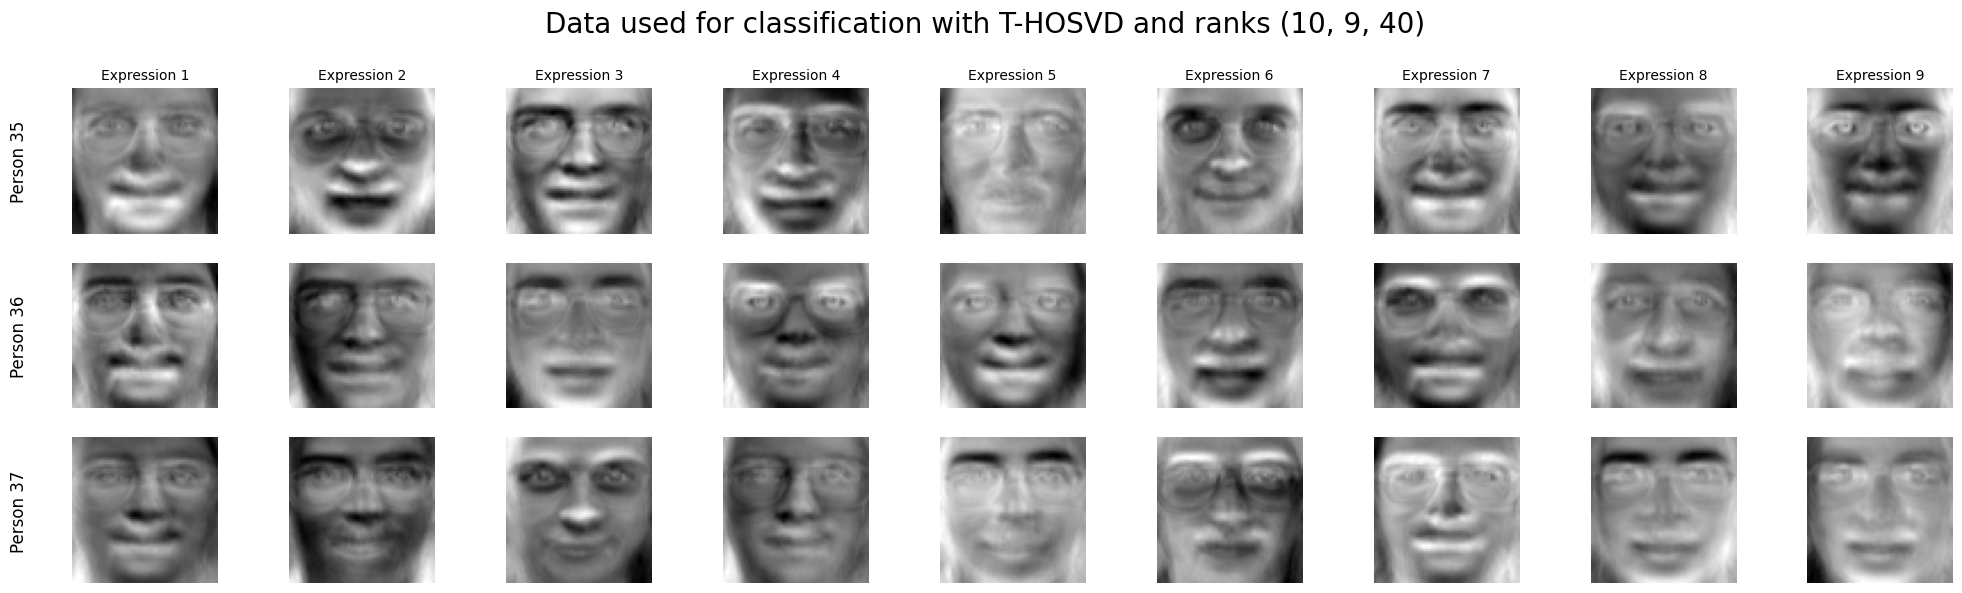

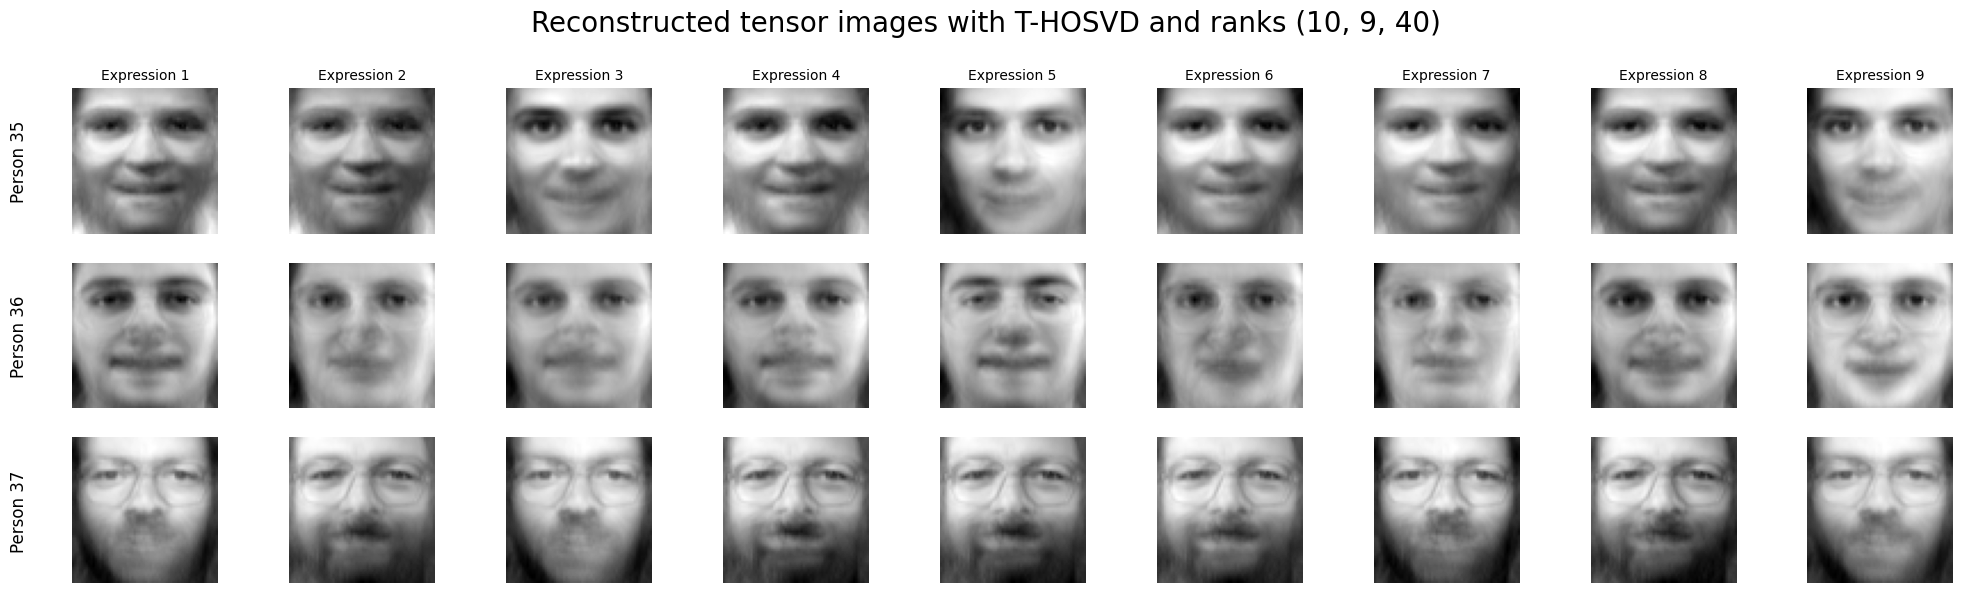

In [20]:
fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))

fig.suptitle(f'Data used for classification with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = C[:, :, person_index].T 
    person_images = person_images.reshape(-1, 64, 64) 

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

A= tl.tenalg.mode_dot(C, H, mode=2)

fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))
fig.suptitle(f'Reconstructed tensor images with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = A[:, :, person_index].T 
    person_images = person_images.reshape(-1, 64, 64)  

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

STUDYING THE TRUNCATION ON THE TRAINING SET

In [21]:
accuracies = [] 
test_values = list(range(10, 100, 1)) 

for test in test_values:
    ranks=[test,n_e,n_p]
    S, factors, singulars = t_hosvd(tensor, ranks)
    F,G,H = factors
    C=tl.tenalg.multi_mode_dot(S,[F, G])

    C_e_list=[]
    for e in range(n_e):
        C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
        C_e_list.append(C_e)

    B_e_list = []
    for C_e in C_e_list:
        B_e = F.T @ C_e
        B_e_list.append(B_e)


    misclassified_qr=0

    for index in range(0,train_images.shape[0]-1):
        z=train_images[index].flatten()
        z_hat = np.dot(F.T, z)
        d = np.zeros((n_e, n_p)) 

        for e in range(n_e):
            Q_e, R_e = qr(B_e_list[e], mode='economic')
            alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

            for p in range(n_p):  
                d[e, p] = np.linalg.norm(alpha_e - H[p, :])


        min_distances_per_person = np.min(d, axis=0)
        min_distance_total = np.min(min_distances_per_person) 
        person_with_min_distance = np.argmin(min_distances_per_person)

        if train_labels[index]!=person_with_min_distance:
            misclassified_qr+=1


    print(f'****************************************************')
    print(f'Ranks: {ranks}')
    print(f'Number of misclassified images: {misclassified_qr}')
    accuracy_qr = 1 - misclassified_qr/train_images.shape[0]
    print(f'Accuracy: {accuracy_qr * 100:.2f}%')
    accuracies.append(accuracy_qr * 100) 


****************************************************
Ranks: [10, 9, 40]
Number of misclassified images: 91
Accuracy: 74.72%
****************************************************
Ranks: [11, 9, 40]
Number of misclassified images: 82
Accuracy: 77.22%
****************************************************
Ranks: [12, 9, 40]
Number of misclassified images: 60
Accuracy: 83.33%
****************************************************
Ranks: [13, 9, 40]
Number of misclassified images: 40
Accuracy: 88.89%
****************************************************
Ranks: [14, 9, 40]
Number of misclassified images: 25
Accuracy: 93.06%
****************************************************
Ranks: [15, 9, 40]
Number of misclassified images: 25
Accuracy: 93.06%
****************************************************
Ranks: [16, 9, 40]
Number of misclassified images: 11
Accuracy: 96.94%
****************************************************
Ranks: [17, 9, 40]
Number of misclassified images: 11
Accuracy: 96.94%
********

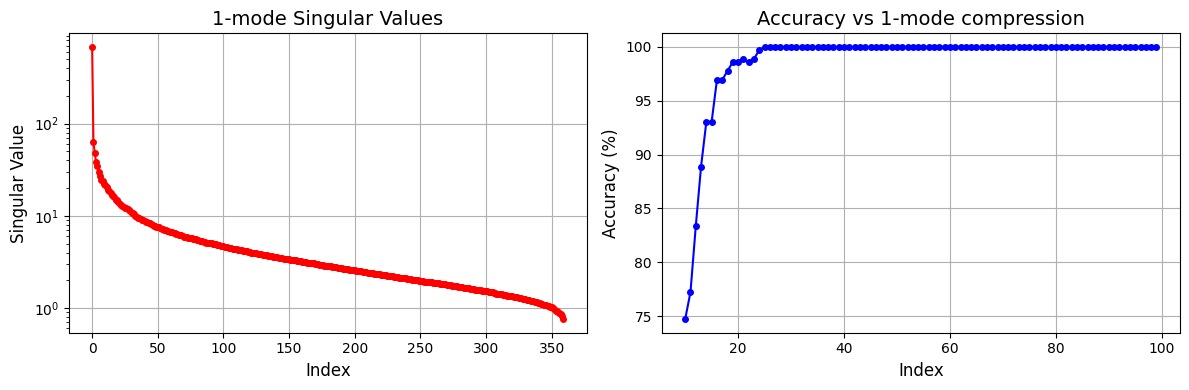

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Singular Values
axes[0].plot(singular_first_mode, marker='o', linestyle='-', color='red', markersize=4)
axes[0].set_yscale('log')
axes[0].set_title("1-mode Singular Values", fontsize=14)
axes[0].set_xlabel("Index", fontsize=12)
axes[0].set_ylabel("Singular Value", fontsize=12)
axes[0].grid(True)

# Accuracy vs r_i
axes[1].plot(test_values, accuracies, marker='o', linestyle='-', color='blue', markersize=4)
axes[1].set_title("Accuracy vs 1-mode compression", fontsize=14)
axes[1].set_xlabel("Index", fontsize=12)
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].grid(True)

# Adatta il layout
plt.tight_layout()
plt.show()

Fixing k=25

In [23]:
ranks=[25,n_e,n_p]
S, factors, singulars = t_hosvd(tensor,ranks)
F,G,H = factors
C=tl.tenalg.multi_mode_dot(S,[F, G])

C_e_list=[]
for e in range(n_e):
    C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
    C_e_list.append(C_e)

B_e_list = []
for C_e in C_e_list:
    B_e = F.T @ C_e
    B_e_list.append(B_e)

misclassified_qr=0

for index in range(0,train_images.shape[0]-1):
    z=train_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if train_labels[index]!=person_with_min_distance:
        misclassified_qr+=1

print(f'Ranks: {ranks}')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/train_labels.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

Ranks: [25, 9, 40]
Number of misclassified images: 0
Accuracy: 100.00%


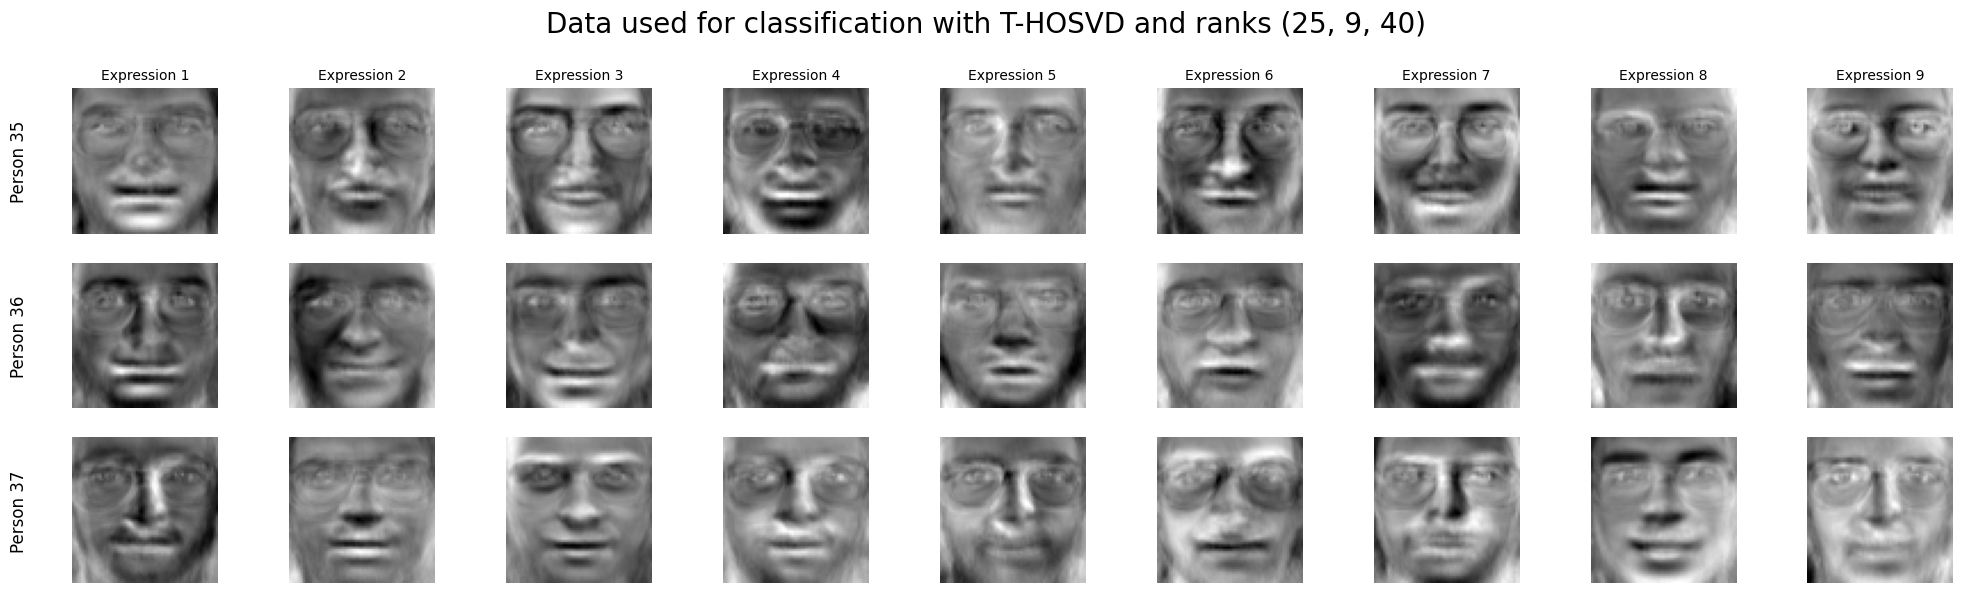

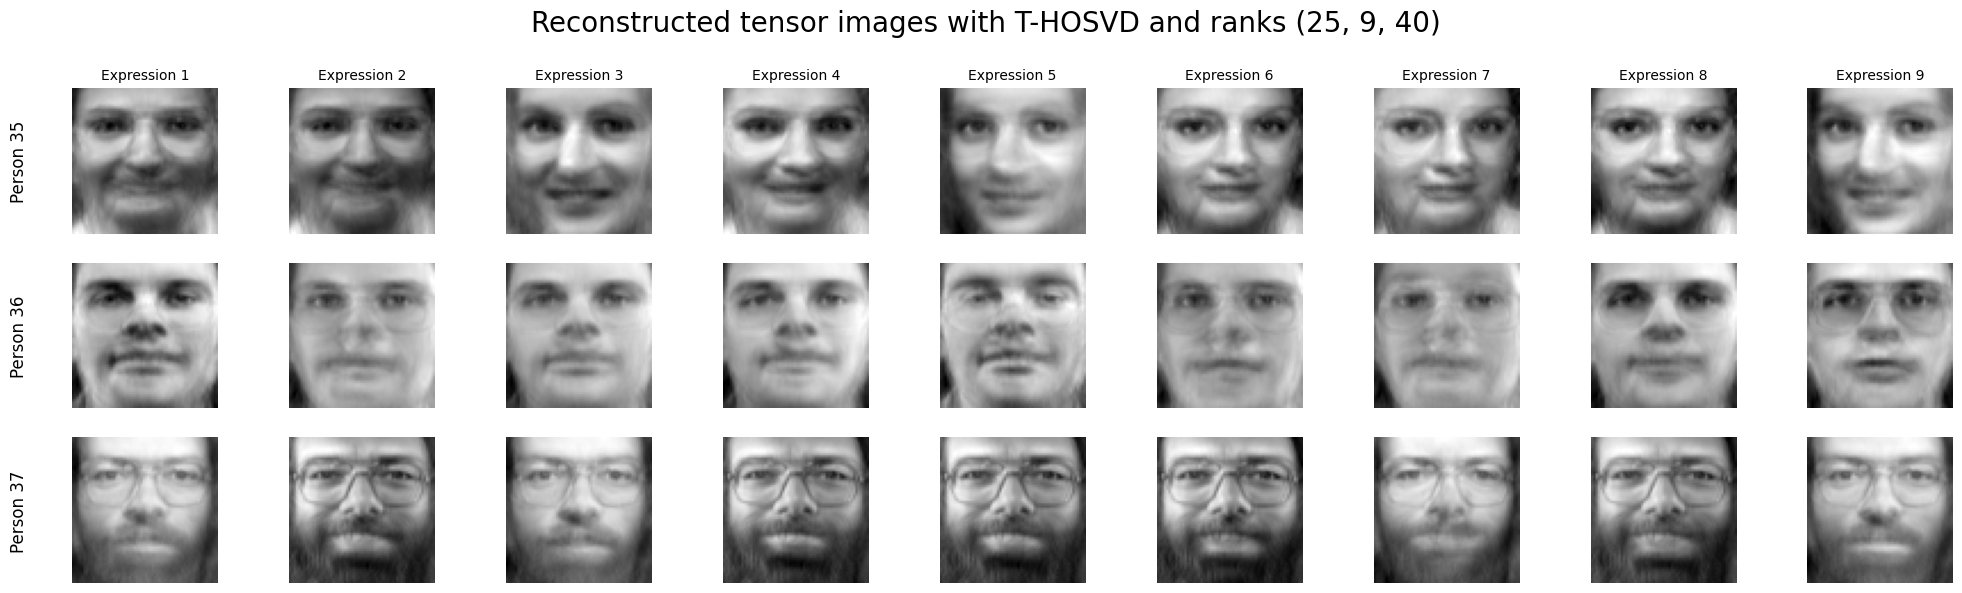

In [24]:
fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))

fig.suptitle(f'Data used for classification with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = C[:, :, person_index].T  # (10, 4096)
    person_images = person_images.reshape(-1, 64, 64)  # (10, 64, 64)

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

A= tl.tenalg.mode_dot(C, H, mode=2)

fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))
fig.suptitle(f'Reconstructed tensor images with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = A[:, :, person_index].T  # (10, 4096)
    person_images = person_images.reshape(-1, 64, 64)  # (10, 64, 64)

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

STUDYING THE TRUNCATION ON THE TESTING SET

In [25]:
accuracies = []  
test_values = list(range(10, 200, 1))
for test in test_values:
    ranks=[test,n_e,n_p]
    S, factors, singulars = t_hosvd(tensor, ranks)
    F,G,H = factors
    C=tl.tenalg.multi_mode_dot(S,[F, G])

    C_e_list=[]
    for e in range(n_e):
        C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
        C_e_list.append(C_e)

    B_e_list = []
    for C_e in C_e_list:
        B_e = F.T @ C_e
        B_e_list.append(B_e)

    misclassified_qr=0
    misclassified_qr=0

    for index in range(0,test_images.shape[0]-1):
        z=test_images[index].flatten()
        z_hat = np.dot(F.T, z)
        d = np.zeros((n_e, n_p)) 

        for e in range(n_e):
            Q_e, R_e = qr(B_e_list[e], mode='economic')
            alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

            for p in range(n_p):  
                d[e, p] = np.linalg.norm(alpha_e - H[p, :])


        min_distances_per_person = np.min(d, axis=0)
        min_distance_total = np.min(min_distances_per_person) 
        person_with_min_distance = np.argmin(min_distances_per_person)

        if test_labels[index]!=person_with_min_distance:
            misclassified_qr+=1

    print(f'****************************************************')
    print(f'Ranks: {ranks}')
    print(f'Number of misclassified images: {misclassified_qr}')
    accuracy_qr = 1 - misclassified_qr/test_images.shape[0]
    print(f'Accuracy: {accuracy_qr * 100:.2f}%')
    accuracies.append(accuracy_qr * 100) 


****************************************************
Ranks: [10, 9, 40]
Number of misclassified images: 16
Accuracy: 60.00%
****************************************************
Ranks: [11, 9, 40]
Number of misclassified images: 14
Accuracy: 65.00%
****************************************************
Ranks: [12, 9, 40]
Number of misclassified images: 13
Accuracy: 67.50%
****************************************************
Ranks: [13, 9, 40]
Number of misclassified images: 11
Accuracy: 72.50%
****************************************************
Ranks: [14, 9, 40]
Number of misclassified images: 9
Accuracy: 77.50%
****************************************************
Ranks: [15, 9, 40]
Number of misclassified images: 8
Accuracy: 80.00%
****************************************************
Ranks: [16, 9, 40]
Number of misclassified images: 8
Accuracy: 80.00%
****************************************************
Ranks: [17, 9, 40]
Number of misclassified images: 7
Accuracy: 82.50%
************

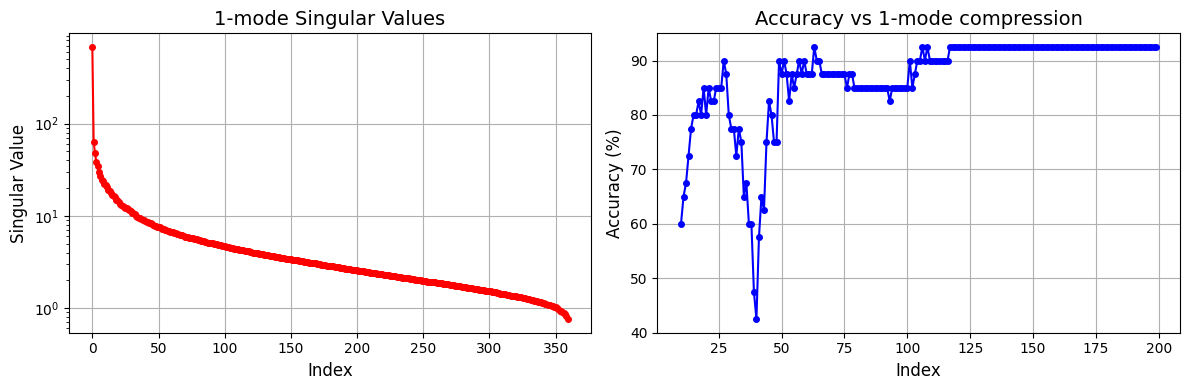

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Singular Values
axes[0].plot(singular_first_mode, marker='o', linestyle='-', color='red', markersize=4)
axes[0].set_yscale('log')
axes[0].set_title("1-mode Singular Values", fontsize=14)
axes[0].set_xlabel("Index", fontsize=12)
axes[0].set_ylabel("Singular Value", fontsize=12)
axes[0].grid(True)

# Accuracy vs r_i
axes[1].plot(test_values, accuracies, marker='o', linestyle='-', color='blue', markersize=4)
axes[1].set_title("Accuracy vs 1-mode compression", fontsize=14)
axes[1].set_xlabel("Index", fontsize=12)
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].grid(True)

# Adatta il layout
plt.tight_layout()
plt.show()

Fixing k=50

In [27]:
ranks=[50,n_e,n_p]
S, factors, singulars = t_hosvd(tensor, ranks)
F,G,H = factors
C=tl.tenalg.multi_mode_dot(S,[F, G])

C_e_list=[]
for e in range(n_e):
    C_e=tl.tenalg.multi_mode_dot(S,[F, G[e,:]])
    C_e_list.append(C_e)

B_e_list = []
for C_e in C_e_list:
    B_e = F.T @ C_e
    B_e_list.append(B_e)

misclassified_qr=0

for index in range(0,test_images.shape[0]-1):
    z=test_images[index].flatten()
    z_hat = np.dot(F.T, z)
    d = np.zeros((n_e, n_p)) 

    for e in range(n_e):
        Q_e, R_e = qr(B_e_list[e], mode='economic')
        alpha_e, _, _, _ = np.linalg.lstsq(R_e, Q_e.T @ z_hat, rcond=None)

        for p in range(n_p):  
            d[e, p] = np.linalg.norm(alpha_e - H[p, :])


    min_distances_per_person = np.min(d, axis=0)
    min_distance_total = np.min(min_distances_per_person) 
    person_with_min_distance = np.argmin(min_distances_per_person)

    if test_labels[index]!=person_with_min_distance:
        misclassified_qr+=1

print(f'Ranks: {ranks}')
print(f'Number of misclassified images: {misclassified_qr}')
accuracy_qr = 1 - misclassified_qr/test_images.shape[0]
print(f'Accuracy: {accuracy_qr * 100:.2f}%')

Ranks: [50, 9, 40]
Number of misclassified images: 5
Accuracy: 87.50%


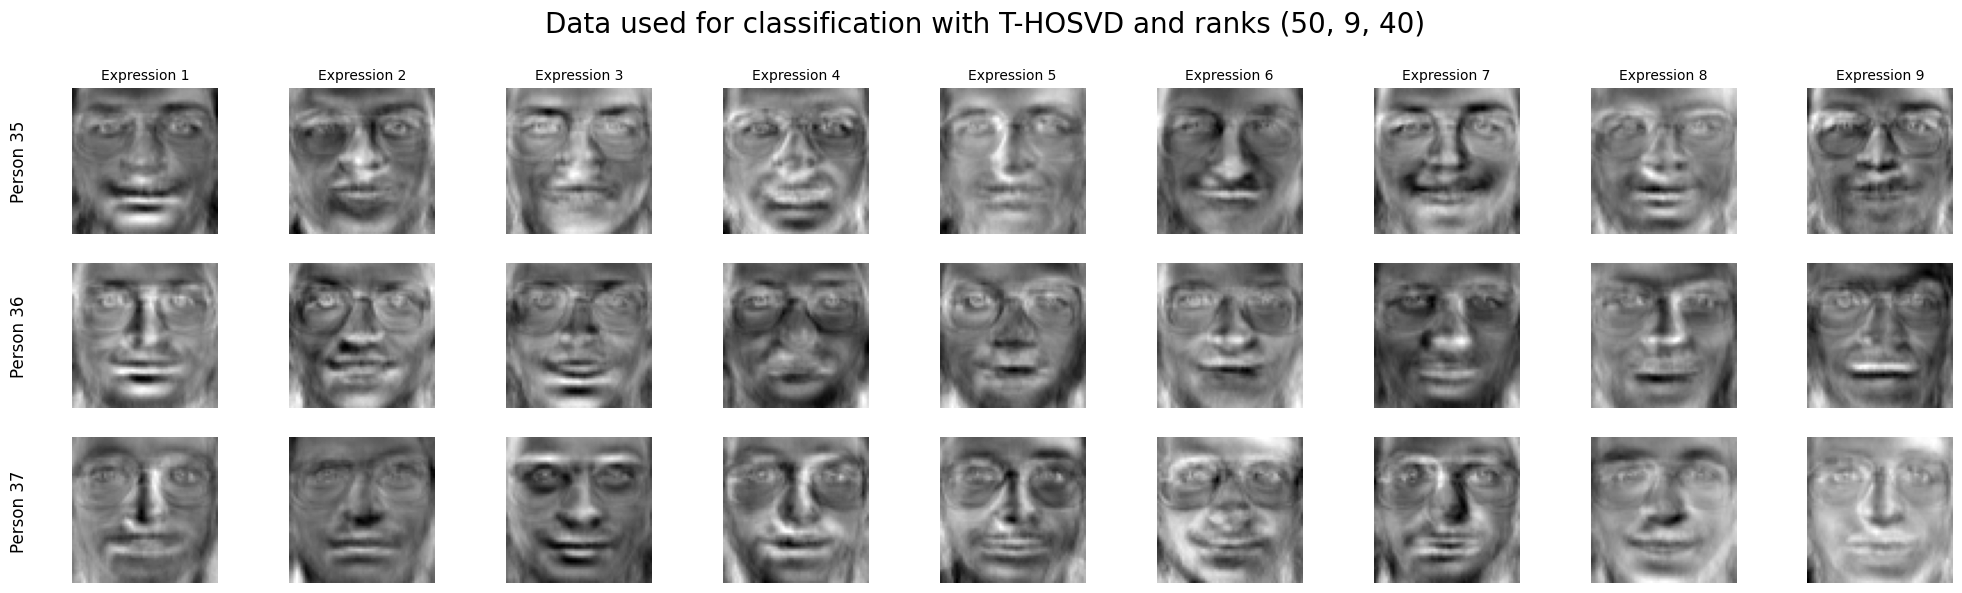

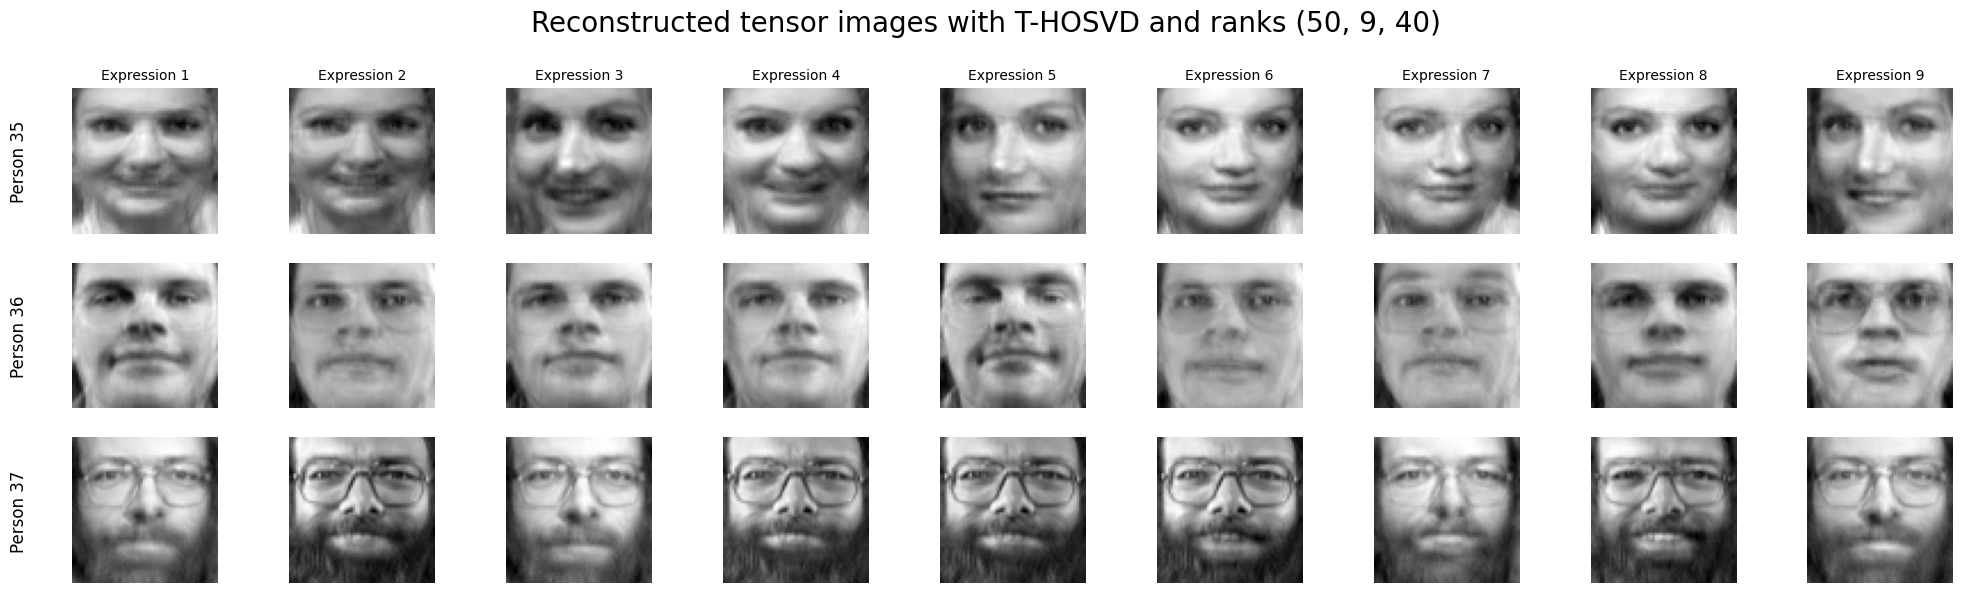

In [28]:
fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))

fig.suptitle(f'Data used for classification with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = C[:, :, person_index].T  # (10, 4096)
    person_images = person_images.reshape(-1, 64, 64)  # (10, 64, 64)

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

A= tl.tenalg.mode_dot(C, H, mode=2)

fig, axes = plt.subplots(len(person_indices), 9, figsize=(20, 6))
fig.suptitle(f'Reconstructed tensor images with T-HOSVD and ranks {S.shape}', fontsize=20)

for row, person_index in enumerate(person_indices):
    person_images = A[:, :, person_index].T  # (10, 4096)
    person_images = person_images.reshape(-1, 64, 64)  # (10, 64, 64)

    for col, ax in enumerate(axes[row]):
        ax.imshow(person_images[col], cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Expression {col+1}", fontsize=10)

    axes[row, 0].text(-20, 32, f"Person {person_index+1}", fontsize=12,
                      ha='right', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.2, hspace=0.2)
plt.show()

## PRESENTATION IMAGES

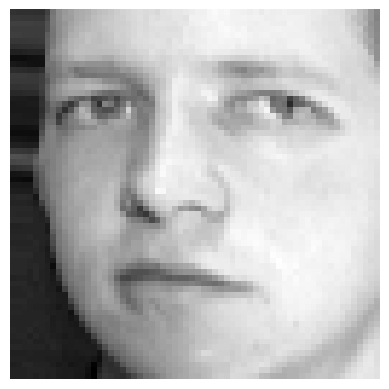

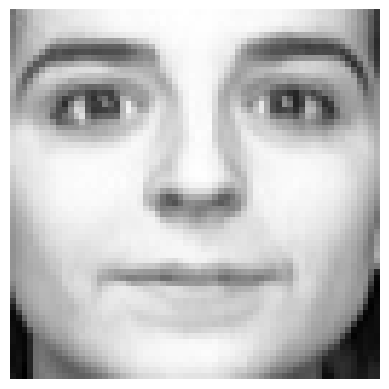

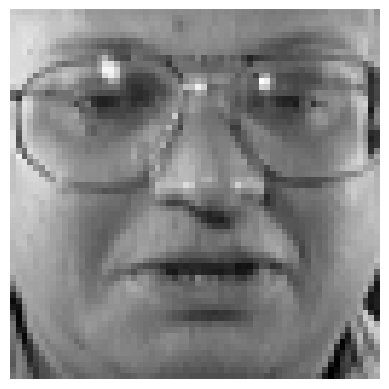

In [29]:
num_images = [3,99,309]

for i in num_images:
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.show()
